## Import libraries and setup

In [1]:
import sys, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# DWave Credentials
dwave_solver = os.getenv('DWAVE_API_SOLVER')
api_key = os.getenv('DWAVE_API_TOKEN')

from dwave.system.samplers import DWaveSampler
from dwave.system.composites import EmbeddingComposite

import dwave_networkx as dnx

### Use NetworkX graphic package to create a graph
import networkx as nx

# Select a D-Wave system and handle mapping from problem graph to sampler graph
sampler = EmbeddingComposite(DWaveSampler(solver=dwave_solver, token=api_key))

## Create Bipartite Graph

In [3]:
from networkx.algorithms import bipartite

# B = nx.Graph()

# # Add nodes with the node attribute "bipartite"
# B.add_nodes_from(['A', 'B', 'C'], bipartite=0)
# B.add_nodes_from(['2', '3', '4'], bipartite=1)

# # Add edges only between nodes of opposite node sets
# B.add_edges_from([('A', '2'), ('A', '3'), 
#                   ('B', '2'), ('B', '4'), 
#                   ('C', '3')])

# Create Random Bipartite Graph
B = bipartite.random_graph(10, 7, p=0.5)
B = nx.to_directed(B)

## Draw Bipartite Graph

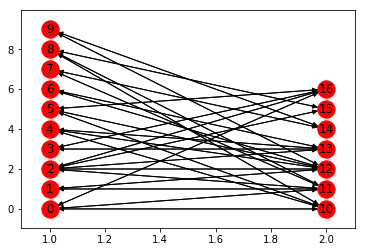

In [5]:
def draw_bp_graph(G):
    X, Y = bipartite.sets(G)
    pos = dict()
    pos.update( (n, (1, i)) for i, n in enumerate(X) ) # put nodes from X at x=1
    pos.update( (n, (2, i)) for i, n in enumerate(Y) ) # put nodes from Y at x=2
    nx.draw_networkx(G, pos=pos)
    plt.show()

draw_bp_graph(B)

## Create Random Relief Order

In [6]:
relief_order = np.random.permutation(10)

In [7]:
relief_order

array([8, 5, 6, 3, 7, 9, 1, 4, 2, 0])

## Create Random Assignments

In [8]:
assignments = {}

for i in range(10, 17):
    possible_AGs = list(B.neighbors(i))
    matched = False
    
    while not matched:
        choice = np.random.choice(possible_AGs)
        if choice not in assignments.values():
            assignments[i] = choice
            matched = True

In [9]:
assignments

{10: 5, 11: 2, 12: 4, 13: 6, 14: 7, 15: 8, 16: 0}

## Find Unmatched AGs

In [10]:
unmatched_ags = np.setdiff1d(np.arange(10), list(assignments.values()))

In [11]:
unmatched_ags

array([1, 3, 9])

## Create Distance Matrix 

In [27]:
# Create temp graph
dist_B = B.copy()

In [28]:
# Change graph so matching are unidirectional: OR -> AG for match, AG -> OR otherwise
for AG, OR in assignments.items():
    dist_B.remove_edge(OR, AG)

for i in range(10):
    edges = list(dist_B.neighbors(i))
    for j in edges:
        dist_B.remove_edge(j,i)

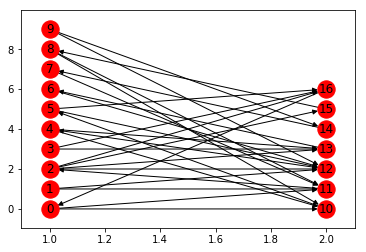

In [29]:
draw_bp_graph(dist_B)

In [ ]:
# Find Target OR and remove Target AG and all edges
relief_order[0]

## Calculate Q and q for Ising

In [15]:
# calculate d vector
d_A = D['A']
d_4 = D['4']
d = []

for k, v in sorted(d_A.items()):
    d.append(v + d_4[k] - D['A']['4'])

d = np.array(d)

In [20]:
# calculate q vector
q = d - 2*np.array([1]*len(d))

# calculate Q matrix
Q = np.ones(shape=(len(d), len(d)), dtype=float)

## Submit Ising to DWave Leap

In [21]:
import dimod

interactions = {}
n,d = Q.shape

for i in range(0, d):
    for j in range(i+1,d):
        interactions[(i,j)] = Q[i,j]

In [22]:
ising_model = dimod.BinaryQuadraticModel.from_ising(list(q), interactions)

In [23]:
resp = dimod.ExactSolver().sample(ising_model)
for datum in resp.data(['sample', 'energy']):
    print(datum.sample, datum.energy)

{0: 1, 1: -1, 2: 1, 3: 1, 4: 1, 5: -1} -11.0
{0: 1, 1: -1, 2: -1, 3: 1, 4: 1, 5: -1} -9.0
{0: -1, 1: -1, 2: 1, 3: 1, 4: 1, 5: -1} -9.0
{0: 1, 1: -1, 2: 1, 3: -1, 4: 1, 5: -1} -9.0
{0: 1, 1: -1, 2: 1, 3: 1, 4: -1, 5: -1} -9.0
{0: 1, 1: 1, 2: 1, 3: -1, 4: 1, 5: -1} -7.0
{0: 1, 1: 1, 2: -1, 3: 1, 4: 1, 5: -1} -7.0
{0: 1, 1: 1, 2: 1, 3: 1, 4: -1, 5: -1} -7.0
{0: -1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1} -7.0
{0: 1, 1: 1, 2: 1, 3: -1, 4: -1, 5: -1} -5.0
{0: -1, 1: 1, 2: 1, 3: -1, 4: 1, 5: -1} -5.0
{0: -1, 1: 1, 2: 1, 3: 1, 4: -1, 5: -1} -5.0
{0: 1, 1: 1, 2: -1, 3: 1, 4: -1, 5: -1} -5.0
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: -1} -5.0
{0: 1, 1: 1, 2: -1, 3: -1, 4: 1, 5: -1} -5.0
{0: -1, 1: 1, 2: -1, 3: 1, 4: 1, 5: -1} -5.0
{0: 1, 1: -1, 2: 1, 3: 1, 4: -1, 5: 1} -3.0
{0: -1, 1: -1, 2: 1, 3: -1, 4: 1, 5: -1} -3.0
{0: 1, 1: -1, 2: 1, 3: -1, 4: 1, 5: 1} -3.0
{0: -1, 1: -1, 2: 1, 3: 1, 4: 1, 5: 1} -3.0
{0: 1, 1: -1, 2: -1, 3: -1, 4: 1, 5: -1} -3.0
{0: 1, 1: -1, 2: -1, 3: 1, 4: 1, 5: 1} -3.0
{0: 1, 1: -1, 2: -